# Compare instantaneous & mean hub-height velocity plots

In [1]:
# Load the libraries                                                                                                                        
import numpy             as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os, sys
import pickle
import pandas as pd
#from netCDF4 import Dataset
import glob

import yaml as yaml
Loader=yaml.safe_load

# Make all plots inline 
%matplotlib inline

In [2]:
# Load the right version of urllib and urlretrieve
if sys.version_info[0] < 3: 
    import urllib
    urlretrieve = urllib.urlretrieve
else:
    import urllib.request
    urlretrieve = urllib.request.urlretrieve

In [3]:
def loadyamldef(yamlfile, extradict={}):
    with open(yamlfile) as f:
        returndict = Loader(f)
    # Get the path to yamlfile
    dirpath = os.path.dirname(yamlfile)
    returndict['dirpath'] = dirpath
    # override any entries in the file
    for k,g in extradict.items():
        returndict[k] = g
    return returndict

def downloadFileIfNeeded(dirpath, filename, urlpath, verbose=True):
    fullfilename = os.path.join(dirpath, filename)
    if os.path.exists(fullfilename):
        if verbose: print('Found '+fullfilename)
        return fullfilename
    else:
        if verbose: print("Downloading "+urlpath)
        urlretrieve(urlpath, fullfilename)
    return fullfilename

In [4]:
def loadPickle(picklefname, encoding='ASCII'):
    pfile = open(picklefname, 'rb')
    db   = pickle.load(pfile, encoding=encoding)
    x    = db['x']
    y    = db['y']
    z    = db['z']
    vx   = db['vx']
    vy   = db['vy']
    vz   = db['vz']
    pfile.close()
    return x, y, z, vx, vy, vz

In [5]:
def makecax(ax, c, fontsize, label=None):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.025)
    kwargs = {'format': '%.2f'}
    cbar=fig.colorbar(c, ax=ax, cax=cax, **kwargs)
    if label is not None:
        cbar.set_label(label, fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    return
    
def setfigtextsize(ax, fsize):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.yaxis.get_offset_text(), ax.xaxis.get_offset_text(), ] + ax.get_xticklabels() + ax.get_yticklabels() ):
        item.set_fontsize(fsize)
        
getdictval = lambda d, key, default: d[key] if key in d else default        

In [6]:
# Edit this list to include data
#           YAML file,                                                dictionary with extra labels and stuff
datasets = [
            ['DATA_FLORIS_GCH_stable/KingPlainsField.yaml',                        {'label':'FLORIS GCH Model'}],    
            ['DATA_SNL_Stable_naluwind_KP/DATA_SNL_Stable_naluwind.yaml',          {'label':'Nalu-Wind SNL','encoding':'latin1', 
                                                                                    'xlim':[0, 9000], 'ylim':[0, 9000], 'xlabel':'x [m]', 'ylabel':'y [m]'}],
            ['DATA_Summit_amrwind_eastkp/DATA_Summit_amrwind_eastkp_stable.yaml',  {'label':'AMR-Wind Summit'}],
]

In [7]:
datadefs = []
for data in datasets:
    datadefs.append(loadyamldef(data[0], extradict=data[1]))

Found DATA_FLORIS_GCH_stable/FLORIS_GCH_stable.p
Found DATA_FLORIS_GCH_stable/FLORIS_GCH_stable.p
Found DATA_SNL_Stable_naluwind_KP/DATA_SNL_Stable_naluwind_KP_z89_wturb_inst.pkl
Found DATA_SNL_Stable_naluwind_KP/DATA_SNL_Stable_naluwind_KP_z89_wturb_mean.pkl


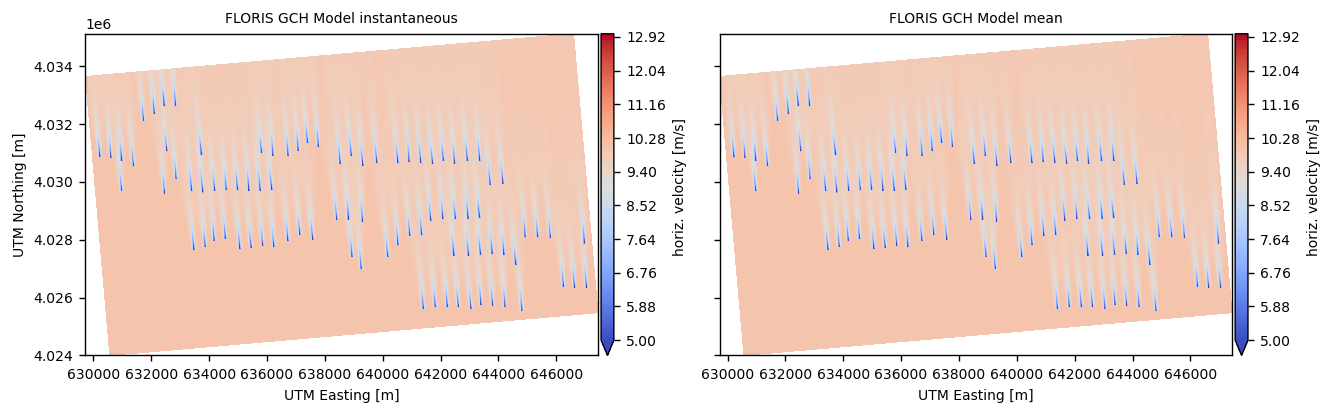

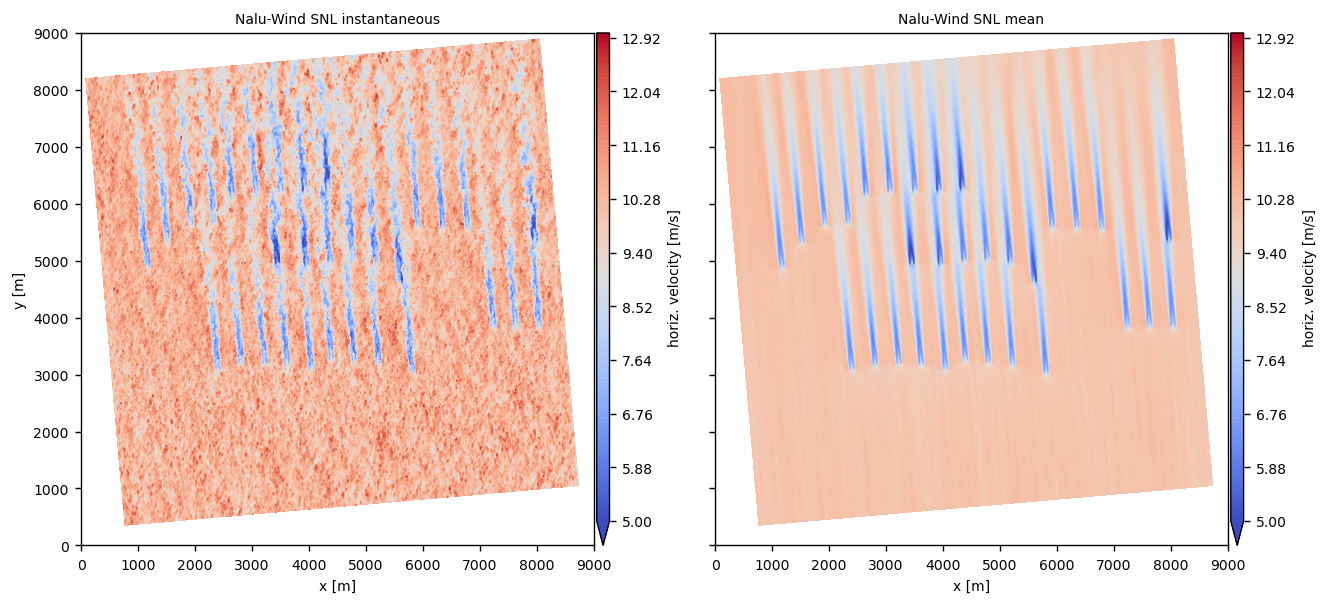

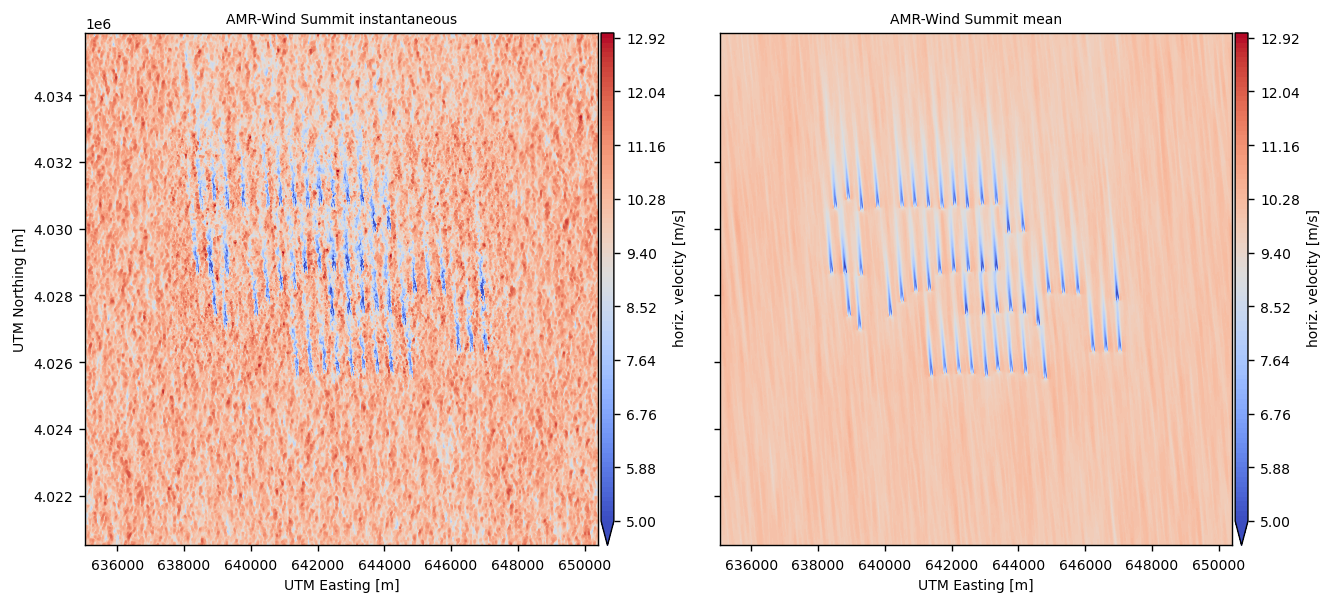

In [8]:
# Plot all farm cases
vlevels = np.linspace(5,13,101)
runtype   = 'turbinerun'
farm      = 'KingPlains'
fontsize  = 8

for data in datadefs:
    dirpath  = data['dirpath']
    encoding = data['encoding'] if 'encoding' in data else 'ASCII'
    fig, axs = plt.subplots(1,2,figsize=(12,6), dpi=125, sharey=True)
    
    filename = data[farm]['instantaneous'][runtype]['filename']
    url      = getdictval(data[farm]['instantaneous'][runtype], 'url', '')
    fullfilename = downloadFileIfNeeded(dirpath, filename, url)    
    ax=axs[0]
    x, y, z, vx, vy, vz = loadPickle(fullfilename, encoding=encoding)
    vh = np.sqrt(vx**2 + vy**2) 
    plotv = vh if len(vh.shape)==2 else vh[0,:,:]
    c=ax.contourf(x, y, plotv, levels=vlevels, cmap='coolwarm', extend='min')
    ax.set_title(data['label']+' instantaneous')
    ax.set_aspect('equal')
    makecax(ax, c, fontsize, label='horiz. velocity [m/s]')
    if 'xlim' in data: ax.set_xlim(data['xlim'])
    if 'ylim' in data: ax.set_ylim(data['ylim'])
    ax.set_xlabel(getdictval(data, 'xlabel', 'UTM Easting [m]'))
    ax.set_ylabel(getdictval(data, 'ylabel', 'UTM Northing [m]'))    
    setfigtextsize(ax, fontsize)
    
    filename = data[farm]['mean'][runtype]['filename']
    url      = getdictval(data[farm]['mean'][runtype], 'url', '')
    fullfilename = downloadFileIfNeeded(dirpath, filename, url)    
    ax=axs[1]
    x, y, z, vx, vy, vz = loadPickle(fullfilename, encoding=encoding)
    vh = np.sqrt(vx**2 + vy**2) 
    plotv = vh if len(vh.shape)==2 else vh[0,:,:]
    c=ax.contourf(x, y, plotv, levels=vlevels, cmap='coolwarm', extend='min')
    ax.set_title(data['label']+' mean')
    ax.set_aspect('equal')
    makecax(ax, c, fontsize, label='horiz. velocity [m/s]')
    if 'xlim' in data: ax.set_xlim(data['xlim'])
    if 'ylim' in data: ax.set_ylim(data['ylim'])
    ax.set_xlabel(getdictval(data, 'xlabel', 'UTM Easting [m]'))
    setfigtextsize(ax, fontsize)